# Similar Product Recommender system using Deep Learning for an online e-commerce store
> A tutorial on building a recommender that will allow users to select a specific type of shirt and search for similar pattern of shirts from the inventory

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F97a41524-c5f4-4746-8fe8-e244bee3f8ad%2FUntitled.png?table=block&id=826e1b75-907e-4e19-aa22-cb6de8c16103&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

## Import libraries required for file operations

In [ ]:
import os
import pickle
from glob import glob

# import basic numerical libraries
import numpy as np
import pandas as pd

# import keras libraries for image recognition
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage

## Data preparation

In [ ]:
#hide-output
# download and unzip shirts folder from the directory
!wget https://raw.githubusercontent.com/sparsh-ai/rec-data-public/master/shirts.zip
!unzip shirts.zip

In [ ]:
# Create a dictionary of shirts for feeding to the image recognition model
shirts_dict = dict()
for shirt in glob('shirts/*.jpg'):  # load all shirts
  img = kimage.load_img(shirt, target_size=(224, 224))   # VGG accepts images in 224 X 224 pixels
  img = preprocess_input(np.expand_dims(kimage.img_to_array(img), axis=0))  # so some preprocessing
  id = shirt.split('/')[-1].split('.')[0]
  shirts_dict[id] = img  # map image & shirt id

In [ ]:
#hide-input
no_of_shirts = len(shirts_dict.keys())
print('Number of shirts = {}'.format(no_of_shirts))

Number of shirts = 2908


<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Ff2575048-a33e-4eb0-a9f1-2619b341fc05%2FUntitled.png?table=block&id=57a0456c-908e-47be-8aad-a16ea7661ea4&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

## Model training

In [ ]:
# Train on the VGG Model
model = VGG16(include_top=False, weights='imagenet')

shirts_matrix = np.zeros([no_of_shirts, 25088])   # initialize the matrix with zeros
for i, (id, img) in enumerate(shirts_dict.items()):  
  shirts_matrix[i, :] = model.predict(img).ravel()  # flatten the matrix

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F1670ccb0-ed4b-452f-b17b-436987b8f1e8%2FUntitled.png?table=block&id=ce9a72be-0e8e-43cf-91c5-2e4cf1fa2dff&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

## Inference pipeline

In [ ]:
#hide
# Create a corelation between shirts
dot_product = shirts_matrix.dot(shirts_matrix.T)
norms = np.array([np.sqrt(np.diagonal(dot_product))])
similarity = dot_product / (norms * norms.T)
print(similarity.shape)

(2908, 2908)


In [ ]:
#hide
type(similarity)

numpy.ndarray

In [ ]:
# create a cross reference matrix with shirts and matrix
matrix_id_to_shirt_id = dict()
shirt_id_to_matrix_id = dict()
for i, (id, img) in enumerate(shirts_dict.items()):  
    matrix_id_to_shirt_id[i] = id
    shirt_id_to_matrix_id[id] = i

In [ ]:
#hide
type(matrix_id_to_shirt_id)

dict

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F69f3b94d-d933-4961-8615-e3e9f6f9331f%2FUntitled.png?table=block&id=a3b116d2-ccbd-4062-a6de-216d293684d1&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

##Finding top 10 similar shirts 

### Display the sample shirt

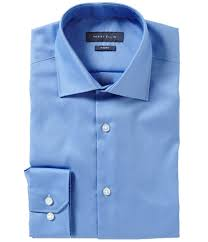

In [ ]:
# Display the sample shirt
from IPython.display import Image
Image('shirts/1015.jpg')

In [ ]:
#hide
# evaluate on shirt "1015"
target_shirt_id = '1015'
target_id = shirt_id_to_matrix_id[target_shirt_id]

# Sort 10 shirts based on their closest corelation
closest_ids = np.argsort(similarity[target_id, :])[::-1][0:10]
closest_shirts = [matrix_id_to_shirt_id[matrix_id] for matrix_id in closest_ids]

closest_shirts

['1015',
 '1308',
 '1187',
 '2554',
 '2420',
 '2526',
 '1174',
 '2197',
 '2545',
 '1290']

### Print images of top-10 similar shirts

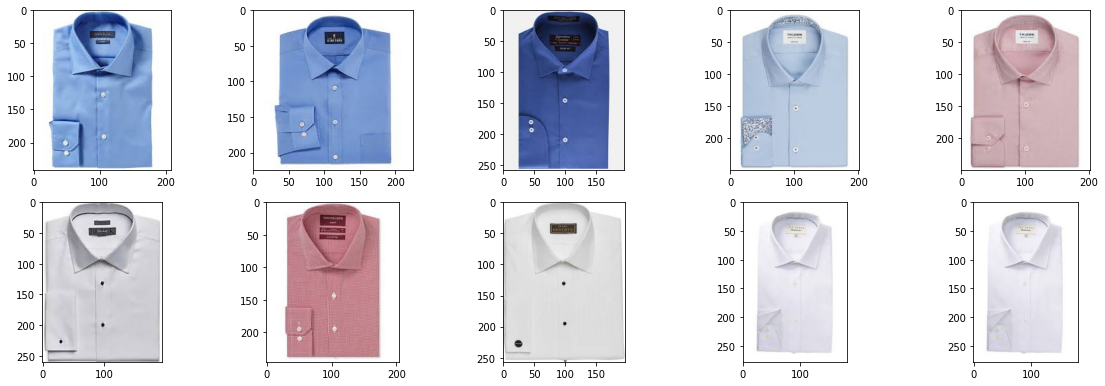

In [ ]:
#collapse-input
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []

for shirt in closest_shirts:
  shirt = 'shirts/'+shirt+'.jpg'
  for img_path in glob.glob(shirt):
      images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## Model persistence

In [ ]:
#hide-output
from sklearn.externals import joblib
joblib.dump(similarity, 'similarity.pkl')
joblib.dump(shirt_id_to_matrix_id, 'shirt_id_to_matrix_id.pkl')
joblib.dump(matrix_id_to_shirt_id, 'matrix_id_to_shirt_id.pkl')

In [ ]:
# load the model from disk
loaded_model = joblib.load('similarity.pkl')

In [ ]:
#hide
type(loaded_model)

numpy.ndarray

In [ ]:
# Sort 10 shirts based on their closest corelation
closest_ids = np.argsort(loaded_model[target_id, :])[::-1][0:10]
closest_shirts = [matrix_id_to_shirt_id[matrix_id] for matrix_id in closest_ids]
closest_shirts

['1015',
 '1308',
 '1187',
 '2554',
 '2420',
 '2526',
 '1174',
 '2197',
 '2545',
 '1290']

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F565c8763-7a3e-477a-93a7-345806d090af%2FUntitled.png?table=block&id=a4f10958-7385-49cc-998e-69f5d02d8da2&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

[Credits](https://www.analyticsvidhya.com/)